# wavelength 0.65nm

In [1]:
import sys
module_path = 'C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT'
sys.path.insert(1, module_path)
import Meta_SCMT
import numpy as np
import matplotlib.pyplot as plt

In [2]:
GP = {
    'dim' : 1, #dim : 1 or 2.
    'modes' : 1, #number of modes with in a single waveguide. modes <= 2 is usually good enough.
    'period' : 0.24,
    'res' : 20, #resolution within one period
    'downsample_ratio': 1, #between (0, 1] for the output periodic resolution, it will be int(round(downsample_ratio * res))
    'wh' : 0.8, #waveguide height
    'lam' : 0.65,
    'n_sub' : 1.46, #the refractive index of substrate.
    'n_wg' : 2.27,# the refractive index of waveguide
    'h_min' : 0.03, #h_min, and h_max define the range of the width of waveguide.
    'h_max' : 0.23,
    'dh' : 0.01, #the step size of h.
    'path' : "sim_cache_650nm/", #the inter state store path            
}
sim = Meta_SCMT.Sim(**GP)

# gen library for PBA design

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:51<00:00,  2.46s/it]


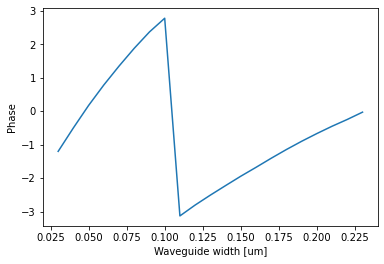

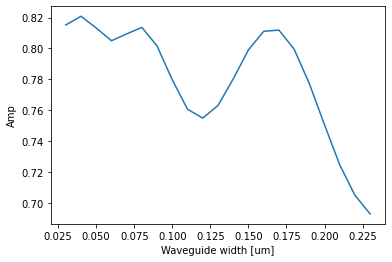

PBA width phase map saved.


In [3]:
sim.PBA.gen_lib(vis = True, backend = 'grcwa', step_size = 0.01)

In [4]:
#sim.PBA.gen_lib(vis = True, backend = 'tidy3d')

# From step 1 to step 3, you parpare the data and model you need to build a SCMT model. Once done, the cache data is stored in "sim_cache_1D" directory. When you need to run or build your model agian, you just load the data from cache.

# step1 generate modes

# it's ok to see warning like invalid value encountered in sqrt. This is because when using fsolve function, it can feed bad bata in function. This won't influence the final results.

In [5]:
sim.gen_modes.gen(load = False)
sim.gen_modes.count_modes()

C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT\Meta_SCMT\SCMT_utils\modes1D.py:128: RuntimeWarning: invalid value encountered in sqrt
  gamma = np.sqrt(beta**2 - (k*n0)**2)
C:\Users\94735\.conda\envs\pytorch1.9_env\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT\Meta_SCMT\SCMT_utils\modes1D.py:129: RuntimeWarning: invalid value encountered in sqrt
  kai = np.sqrt((k*n1)**2 - beta**2)
C:\Users\94735\.conda\envs\pytorch1.9_env\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


generated modes lib saved at:sim_cache_650nm/modes_lib.npy
total keys:  21
number of non zero modes:  [21.]


# step 1.1 check correctness of the generated modes.

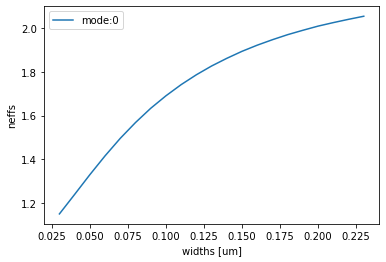

In [6]:
sim.gen_modes.vis_neffs()

# get coupling strength

In [9]:
C_input, C_map = sim.fftting_C.gen_fitting_data(load = False)
coupling_strength = sim.fftting_C.gen_strength_of_coupling(C_map)

100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 190.01it/s]

C dataset generated. dataset size: 2646
C dataset saved.
0.24630337089446566


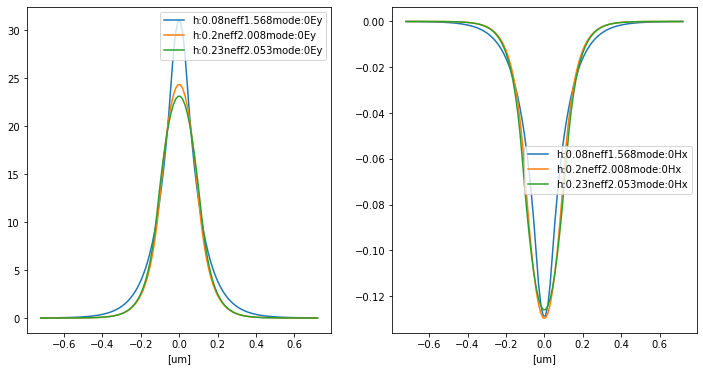

In [10]:
# randomly visualize some generated modes.
H = [0.08, 0.2, 0.23]
sim.gen_modes.vis_field(H)

# step 2, fit a function (the fully connected network) to output the effective refractive index given a width of waveguide. this function will be used in the SCMT model. (The solid line represent the original data, dashed line represent the function output).
# after the fitting the data will be saved in the "sim_cache..." directory. 

using device:  cuda
decay_rate: 0.79
total epoches:10000 [curr:    0 relative_error:103.626000%].
total epoches:10000 [curr: 1000 relative_error:0.783000%].
total epoches:10000 [curr: 2000 relative_error:0.228000%].
total epoches:10000 [curr: 3000 relative_error:0.237000%].
total epoches:10000 [curr: 4000 relative_error:0.214000%].
total epoches:10000 [curr: 5000 relative_error:0.208000%].
total epoches:10000 [curr: 6000 relative_error:0.249000%].
total epoches:10000 [curr: 7000 relative_error:0.179000%].
total epoches:10000 [curr: 8000 relative_error:0.178000%].
total epoches:10000 [curr: 9000 relative_error:0.177000%].
total epoches:10000 [curr: 9999 relative_error:0.176000%].
fitting error > 0.1%, increase total steps or number of layers in fullconnected network.(note: < 1% is good enough, but < 0.1% is the safest.)
model saved.


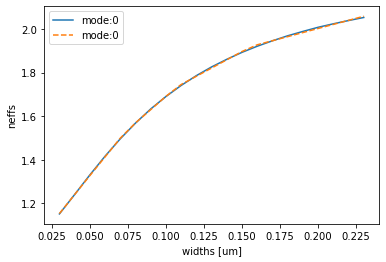

In [11]:
sim.fitting_neffs.fit(vis=True, layers = 4, nodes = 128)

# step 2.1 check the correctness of fitting.

In [12]:
neffs = sim.fitting_neffs.apply(H)
print(neffs)

[[1.5689175]
 [2.0025492]
 [2.0587037]]


# step 3.1 fit a function that given the widths and the distance between two waveguides i and j, output the coupling efficient Cij for the combination of all modes. 
# Eg: fit_c(hi, hj, dis) -> [cij_00, cij_01, cij_10, cij_11] if you have two modes per waveguide.

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 78.18it/s]


C dataset generated. dataset size: 2646
C dataset saved.
using device:  cuda
decay_rate: 0.79
total epoches:10000 [curr:    0 relative_error:91.782000%].
total epoches:10000 [curr: 1000 relative_error:0.772000%].
total epoches:10000 [curr: 2000 relative_error:0.534000%].
total epoches:10000 [curr: 3000 relative_error:0.438000%].
total epoches:10000 [curr: 4000 relative_error:3.934000%].
total epoches:10000 [curr: 5000 relative_error:0.129000%].
total epoches:10000 [curr: 6000 relative_error:0.208000%].
total epoches:10000 [curr: 7000 relative_error:0.076000%].
fitting error < 0.1%, accurate enough, stoped.
model saved.


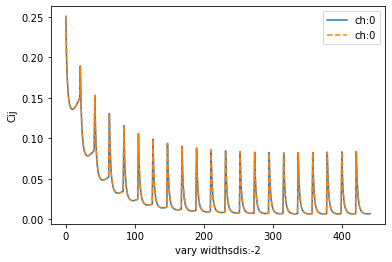

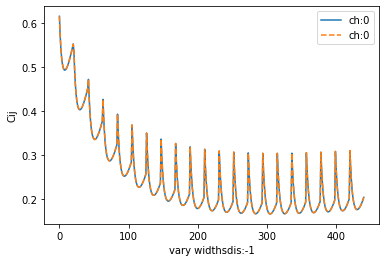

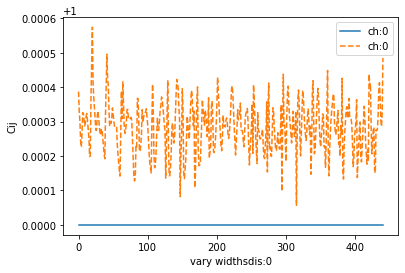

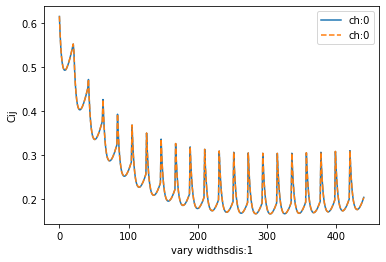

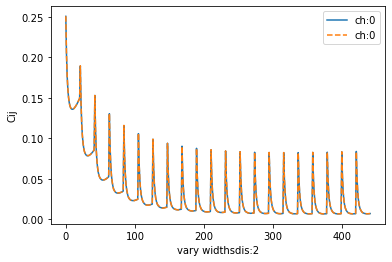

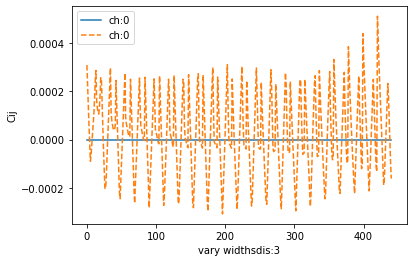

In [13]:
sim.fftting_C.fit(load = False, vis=True, steps = 10000, nodes = 128, layers = 6)

# the max(C_ij) indicate how strong your system's coupling is. the sweet point is below 0.5 but above 0.1, based on experience.

# step 3.2 fit a function that given the width of the waveguide, output the Ey field for each mode.

using device:  cuda
decay_rate: 0.79
total epoches:10000 [curr:    0 relative_error:100.177000%].
total epoches:10000 [curr: 1000 relative_error:15.278000%].
total epoches:10000 [curr: 2000 relative_error:14.868000%].
total epoches:10000 [curr: 3000 relative_error:1.237000%].
total epoches:10000 [curr: 4000 relative_error:0.670000%].
total epoches:10000 [curr: 5000 relative_error:0.501000%].
total epoches:10000 [curr: 6000 relative_error:0.440000%].
total epoches:10000 [curr: 7000 relative_error:0.558000%].
total epoches:10000 [curr: 8000 relative_error:0.450000%].
total epoches:10000 [curr: 9000 relative_error:0.305000%].
total epoches:10000 [curr: 9999 relative_error:0.264000%].
fitting error > 0.1%, increase total steps or number of layers in fullconnected network.(note: < 1% is good enough, but < 0.1% is the safest.)
model saved.


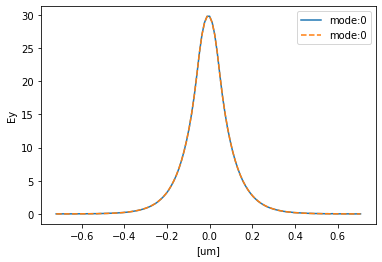

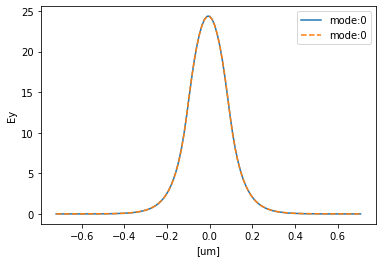

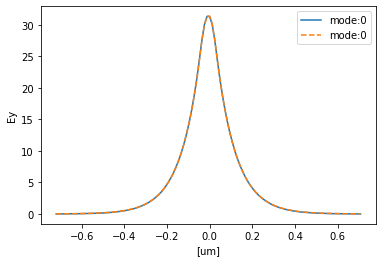

In [14]:
#randomly select 3 modes to visualize
sim.fftting_E.fit(vis=True, nodes = 128, layers = 6)

# step 3.3 fitting K, this is similiar to fit C

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 81.92it/s]


K dataset generated. dataset size: 2646
K dataset saved.
using device:  cuda
decay_rate: 0.79
total epoches:30000 [curr:    0 relative_error:111.484000%].
total epoches:30000 [curr: 3000 relative_error:2.842000%].
total epoches:30000 [curr: 6000 relative_error:1.182000%].
total epoches:30000 [curr: 9000 relative_error:1.277000%].
total epoches:30000 [curr:12000 relative_error:0.287000%].
total epoches:30000 [curr:15000 relative_error:0.278000%].
total epoches:30000 [curr:18000 relative_error:0.252000%].
total epoches:30000 [curr:21000 relative_error:0.141000%].
total epoches:30000 [curr:24000 relative_error:0.204000%].
total epoches:30000 [curr:27000 relative_error:0.073000%].
fitting error < 0.1%, accurate enough, stoped.
model saved.


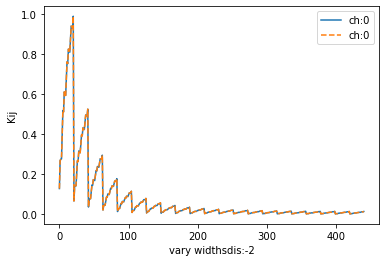

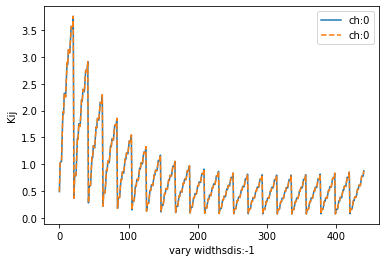

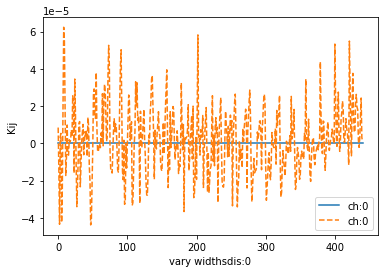

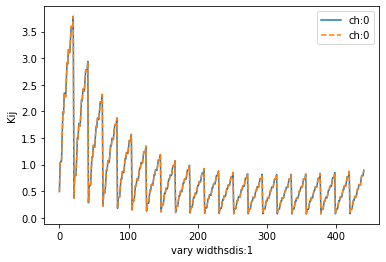

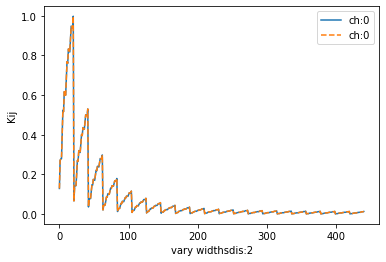

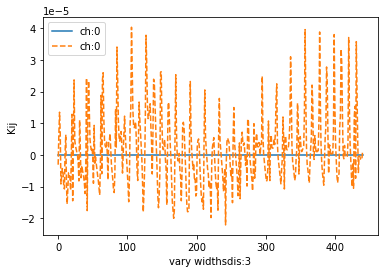

In [15]:
sim.fftting_K.fit(load = False, vis=True, nodes = 128,layers = 6, steps = 30000)

# step 4 run a forward simulation.

coo_sparse generated.
coo_sparse generated.
dis model input generated.
initialized by loaded h_paras.


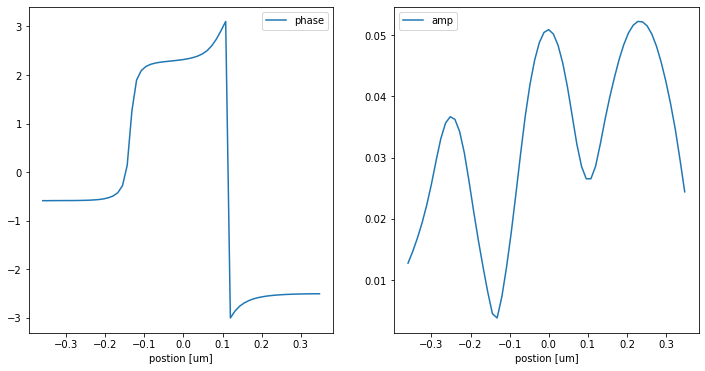

In [16]:
N = 3
#the widths of waveguides.
wgs = np.array([0.08, 0.15, 0.23])
prop_dis = 0.25 * N * GP['period']
#near field. the field at the exit of the waveguides.
sim.scmt.init_model(N, prop_dis, COUPLING = True, init_hs= wgs, far_field= False)
E_out =sim.scmt.forward()
sim.scmt.vis_field(E_out)

coo_sparse generated.
coo_sparse generated.
dis model input generated.
f_kernel generated.
initialized by loaded h_paras.


C:\Users\94735\.conda\envs\pytorch1.9_env\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


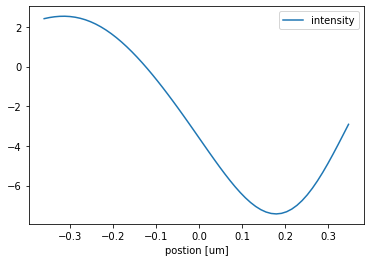

In [17]:
#far field, the field propagates a distance in free space.
sim.scmt.init_model(N, prop_dis, COUPLING = True, init_hs= wgs, far_field= True)
E_out =sim.scmt.forward()
sim.scmt.vis_field(E_out)

# if no coupling: quite different from the scmt case, which indicate the coupling is important in this case.

coo_sparse generated.
coo_sparse generated.
dis model input generated.
initialized by loaded h_paras.
coo_sparse generated.
coo_sparse generated.
dis model input generated.
initialized by loaded h_paras.


Text(0.5, 1.0, 'near field phase by scmt model')

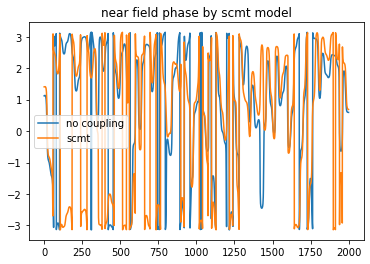

In [18]:
N = 100
#the widths of waveguides.
wgs = np.random.uniform(GP['h_min'], GP['h_max'], (N,))
prop_dis = 0.25 * N * GP['period']
#near field. the field at the exit of the waveguides.
sim.scmt.init_model(N, prop_dis, COUPLING = False, init_hs= wgs, far_field= False)
E_no_coupling =sim.scmt.forward()
sim.scmt.init_model(N, prop_dis, COUPLING = True, init_hs= wgs, far_field= False)
E_scmt =sim.scmt.forward()
plt.figure()
plt.plot(np.angle(E_no_coupling), label = 'no coupling')
plt.plot(np.angle(E_scmt), label = 'scmt')
plt.legend()
plt.title("near field phase by scmt model")

# step 4.1 we do a fullwave simulation using Tidy3d to validate our forward process.

In [176]:
N = 40
theta = 0
NA = 0.8
prop_dis = 0.5 * N * GP['period'] * np.sqrt((1 - NA**2)/NA**2)
#wgs = sim.PBA.design_lens(N, prop_dis, load = True)
#np.save(f"PBA_lens_N{N}_lam{GP['lam']}um.npy", wgs)
#wgs = np.random.uniform(GP['h_min'], GP['h_max'], (N,))
#np.save(f"random_wgs2_N{N}_lam{GP['lam']}um.npy", wgs)
wgs = np.load(f"random_wgs2_N{N}_lam{GP['lam']}um.npy")

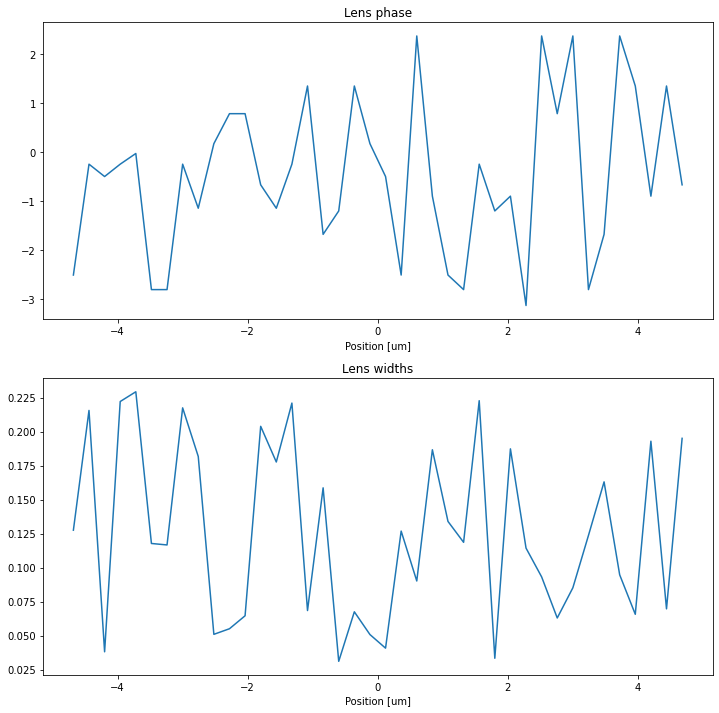

In [177]:
phases = sim.PBA.width_to_phase(wgs, sim.GP.period, load = True, vis = True)

coo_sparse generated.
coo_sparse generated.
dis model input generated.
initialized by loaded h_paras.


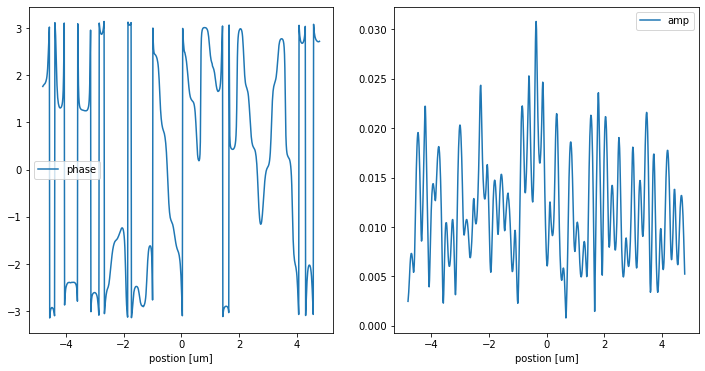

In [178]:
sim.scmt.init_model(N, prop_dis, COUPLING = True, init_hs= wgs, far_field= False)
E_out =sim.scmt.forward(theta = theta)
sim.scmt.vis_field(E_out)
E_scmt = E_out

coo_sparse generated.
coo_sparse generated.
dis model input generated.
initialized by loaded h_paras.


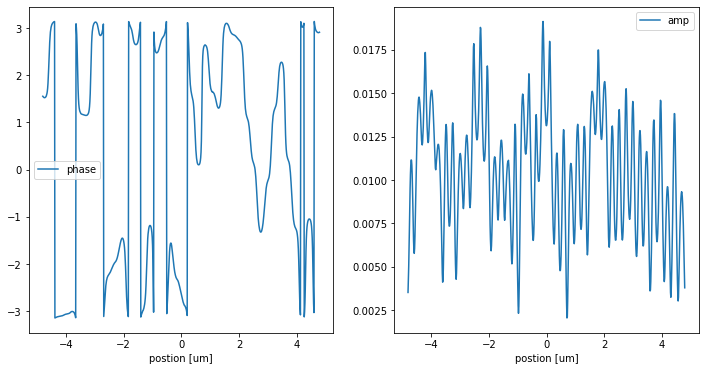

In [179]:
sim.scmt.init_model(N, prop_dis, COUPLING = False, init_hs= wgs, far_field= False)
E_out =sim.scmt.forward(theta = theta)
sim.scmt.vis_field(E_out)
E_no_coupling = E_out

# fullwave

Fullwave resolution: 50
numerical aperture: 0.81
total running time: 1.084083307293225e-12
Initializing simulation...
Mesh step (micron): [2.00e-02, 2.00e-02, 2.00e-02].
Simulation domain in number of grid points: [510, 1, 350].
Total number of computational grid points: 1.78e+05.
Total number of time steps: 31274.
Estimated data size (GB) of monitor monitor: 0.0074.
Estimated data size (GB) of monitor monitor_1: 0.0000.
Estimated data size (GB) of monitor monitor_2: 0.0000.
Estimated data size (GB) of monitor monitor_3: 0.0000.
Estimated data size (GB) of monitor monitor_4: 0.0000.
Estimated data size (GB) of monitor monitor_5: 0.0000.


C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT\Meta_SCMT\fullwave_1D.py:203: UserWarning: Fullwave is expensive and slow. Only do fullwave on small devices. And low resolution can be inaccurate.
  warnings.warn(


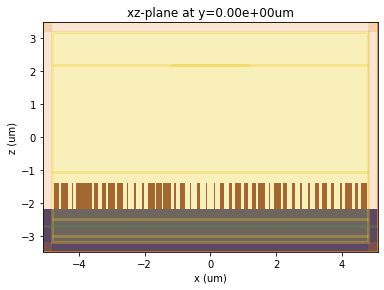

In [150]:
sim.fullwave.init_sim(prop_dis, N, wgs, res = 50, theta = theta, backend = 'tidy3d')

In [151]:
sim.fullwave.upload(task_name="Sep07_1D_random_wgs_N" + str(N))
sim.fullwave.download(data_path="output_tidy3d/")

Uploading the json file...
Project 'Sep07_1D_random_wgs_N40' status: success...                                  

Simulation domain Nx, Ny, Nz: [510, 1, 350]
Applied symmetries: [0, 0, 0]
Number of computational grid points: 1.7850e+05.
Using subpixel averaging: True
Number of time steps: 31274
Automatic shutoff factor: 1.00e-05
Time step (s): 3.4665e-17

Compute source modes time (s):     0.0462
Compute monitor modes time (s):    0.0455


Starting solver...
- Time step    498 / time 1.73e-14s (  1 % done), field decay: 1.00e+00
- Time step   1250 / time 4.33e-14s (  4 % done), field decay: 1.00e+00
- Time step   2501 / time 8.67e-14s (  8 % done), field decay: 1.09e-02
- Time step   3752 / time 1.30e-13s ( 12 % done), field decay: 3.56e-03
- Time step   5003 / time 1.73e-13s ( 16 % done), field decay: 2.91e-03
- Time step   6254 / time 2.17e-13s ( 20 % done), field decay: 1.78e-03
- Time step   7505 / time 2.60e-13s ( 24 % done), field decay: 1.40e-03
- Time step   8756 / time 3.04e-

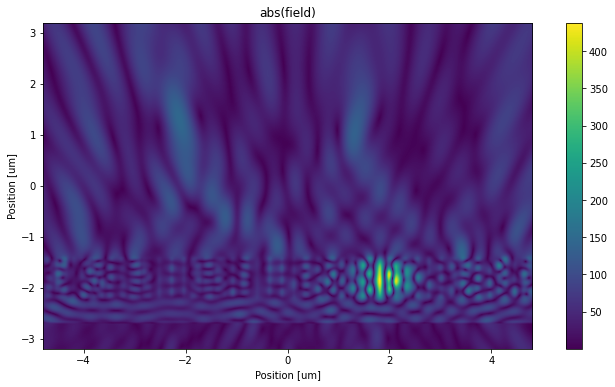

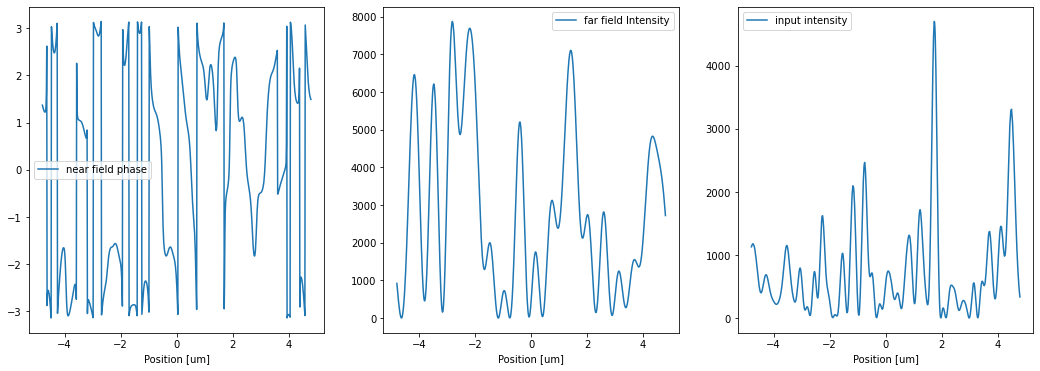

In [152]:
Ey_xz_raw, data_in, data_near, data_far = sim.fullwave.vis_monitor()

fwhm = 2.9400 um, 4.52 $\lambda$
f_kernel generated.
Model initialized.
using device:  cuda
I_in: 1.000000, I_out: 2401.586426, I_out/I_in: 2401.586426.
Ideal focal area power/total_far_field_power = 95.23%
fwhm_airy = 0.3200 um,  0.49 $\lambda$


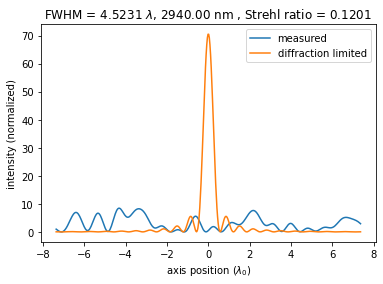

transmission efficiency = 75.98%
far field efficiency = 69.83%
focusing efficiency = 11.01%
focal area power/total_far_field_power = 15.76%


In [153]:
sim.fullwave.results_analysis()

In [154]:
def get_phase_offset(E1, E2):
    L2_dis = np.inf
    theta_opt = 0
    for theta in np.linspace(0, 2 * np.pi, 314 * 2):
        E_temp = E1 * np.exp(1j * theta)
        phase_temp = np.angle(E_temp)
        phase2 = np.angle(E2)
        dis_temp = ((phase_temp - phase2)**2).sum()
        if dis_temp < L2_dis:
            L2_dis = dis_temp
            theta_opt = theta
    print("minimum phase l2 dis:", L2_dis)
    return theta_opt

In [155]:
def cal_l2(E1, E2):
    ph1_offset = get_phase_offset(E1, E2)
    plt.figure(figsize = (20, 10))
    plt.plot(np.angle(E1 * np.exp(1j * ph1_offset)))
    plt.plot(np.angle(E2))
    p_scmt = np.angle(E1 * np.exp(1j * ph1_offset))
    p_fw = np.angle(E2)
    return np.sqrt(np.sum((p_scmt - p_fw)**2))/np.sum(np.abs(p_fw))

minimum phase l2 dis: 3868.0723411736262
L2 pba 0.04156750298473566
minimum phase l2 dis: 2032.2544951890432
L2 scmt 0.03012976117350576


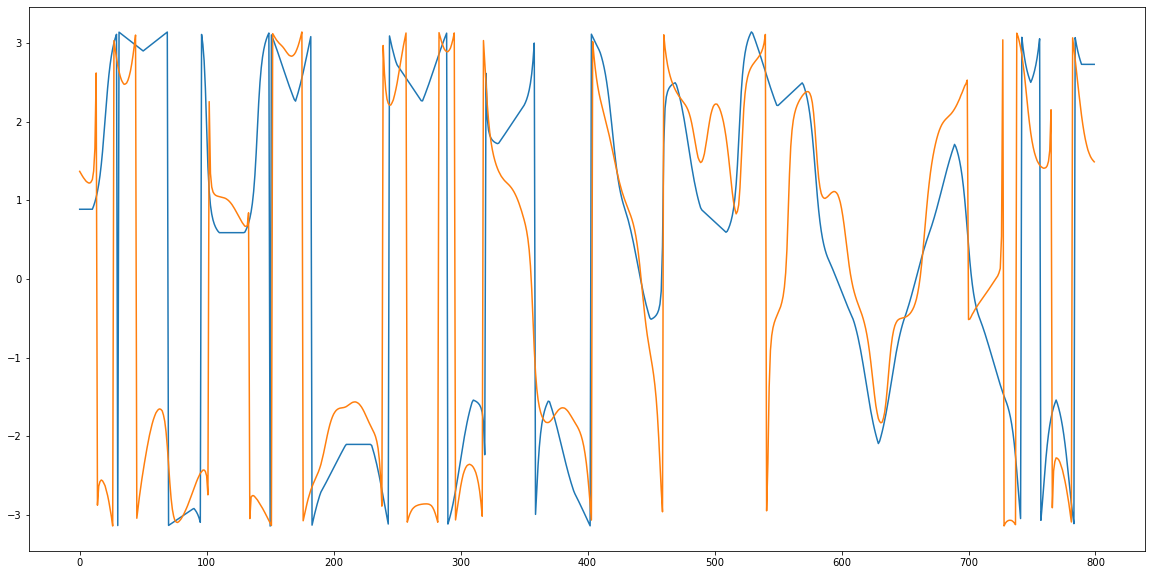

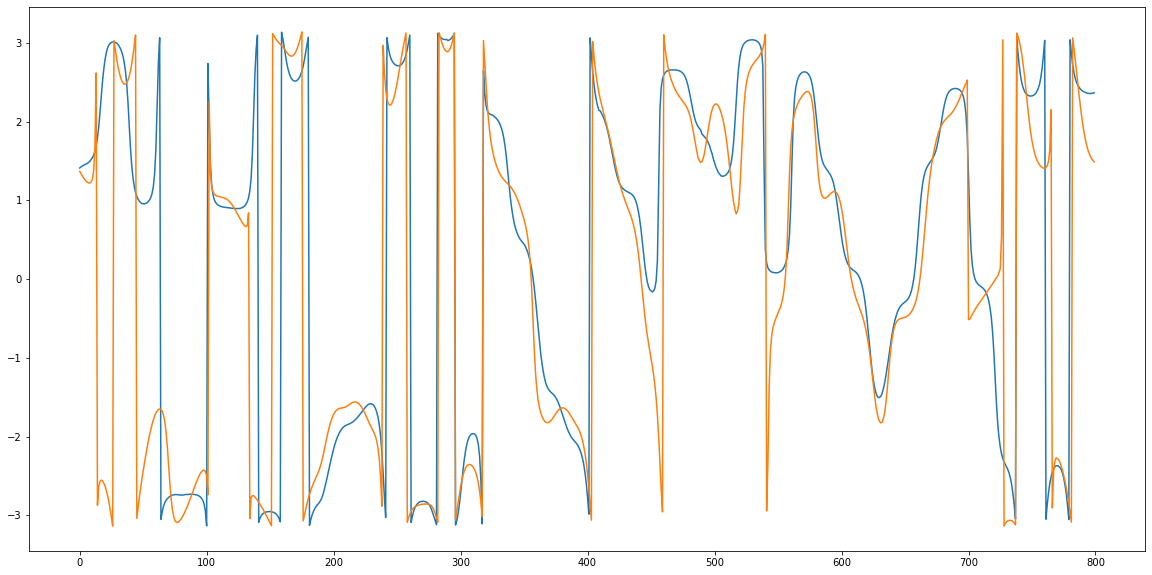

In [156]:
E_fullwave = data_near['Ey']
x = data_near['x']
E_pba = np.exp(1j * phases)
px = (np.arange(E_pba.shape[0]) - (E_pba.shape[0] - 1)/2) * sim.GP.period
E_pba = np.interp(x, px, E_pba)
l2_tmp_pba = cal_l2(E_pba, E_fullwave)
print("L2 pba", l2_tmp_pba)
l2_tmp_scmt = cal_l2(E_scmt, E_fullwave)
print("L2 scmt", l2_tmp_scmt)

In [157]:
E_fullwave = data_near['Ey']
x = data_near['x']
E_pba = np.exp(1j * phases)
px = (np.arange(E_pba.shape[0]) - (E_pba.shape[0] - 1)/2) * sim.GP.period
E_pba = np.interp(x, px, E_pba)

In [158]:
def cal_relative_err(x, ref):
    return np.sqrt(np.sum((x - ref)**2))/np.sum(np.abs(ref))

In [159]:
pba_offset = get_phase_offset(E_pba, E_fullwave)
scmt_offset = get_phase_offset(E_scmt, E_fullwave)
no_coupling_offset = get_phase_offset(E_no_coupling, E_fullwave)
phase_pba = np.angle(E_pba * np.exp(1j * pba_offset))
phase_scmt = np.angle(E_scmt * np.exp(1j * scmt_offset))
phase_no_coupling = np.angle(E_no_coupling * np.exp(1j * no_coupling_offset))
phase_fw = np.angle(E_fullwave)
print("relative error% pba: ", cal_relative_err(phase_pba, phase_fw) * 100)
print("relative error% scmt: ", cal_relative_err(phase_scmt, phase_fw) * 100)
print("relative error% no coupling: ", cal_relative_err(phase_no_coupling, phase_fw) * 100)

minimum phase l2 dis: 3868.0723411736262
minimum phase l2 dis: 2032.2544951890432
minimum phase l2 dis: 4060.2561663173183
relative error% pba:  4.1567502984735665
relative error% scmt:  3.012976117350576
relative error% no coupling:  4.2587618997812795


In [160]:
c = 1000
r = 100
np.sum((phase_pba[c - r: c + r] - phase_fw[c - r: c + r])**2)

0.0

In [161]:
np.sum((phase_scmt[c - r: c + r] - phase_fw[c - r: c + r])**2)

0.0

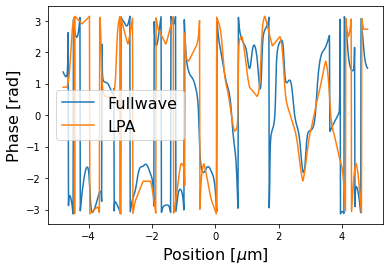

In [170]:
plt.figure()
plt.plot(x, phase_fw, label = 'Fullwave')
plt.plot(x, phase_pba, label = 'LPA')
#plt.plot(x, phase_scmt, label = 'SCMT')
plt.xlabel(r'Position [$\mu$m]',fontsize = 16)
plt.ylabel('Phase [rad]',fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig('near_field_LPA_phase_comparison.eps')

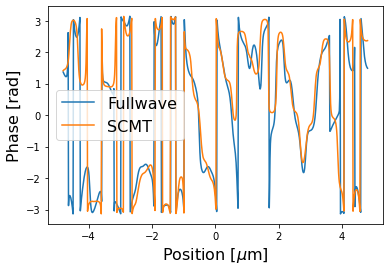

In [171]:
plt.figure()
plt.plot(x, phase_fw, label = 'Fullwave')
#plt.plot(x, phase_pba, label = 'LPA')
plt.plot(x, phase_scmt, label = 'SCMT')
plt.xlabel(r'Position [$\mu$m]',fontsize = 16)
plt.ylabel('Phase [rad]',fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig('near_field_SCMT_phase_comparison.eps')

In [164]:
amp_fullwave = np.abs(E_fullwave)
amp_fullwave_norm = amp_fullwave / np.sqrt(np.sum(amp_fullwave**2))
amp_scmt = np.abs(E_scmt)
amp_scmt_norm = amp_scmt / np.sqrt(np.sum(amp_scmt**2))
amp_no_coupling = np.abs(E_no_coupling)
amp_no_coupling_norm = amp_no_coupling / np.sqrt(np.sum(amp_no_coupling**2))

relative error%:  1.4769022572432027


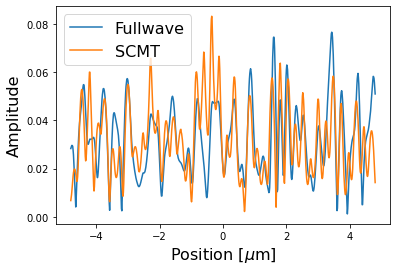

In [172]:
plt.figure()
plt.plot(x, amp_fullwave_norm, label = 'Fullwave')
#plt.plot(x, phase_pba, label = 'LPA')
plt.plot(x, amp_scmt_norm, label = 'SCMT')
plt.xlabel(r'Position [$\mu$m]',fontsize = 16)
plt.ylabel('Amplitude',fontsize = 16)
plt.legend(fontsize = 16)
print("relative error%: ", cal_relative_err(amp_scmt_norm, amp_fullwave_norm) * 100)
plt.savefig('near_field_SCMT_amp_comparison.eps')

relative error%:  1.801207393726991


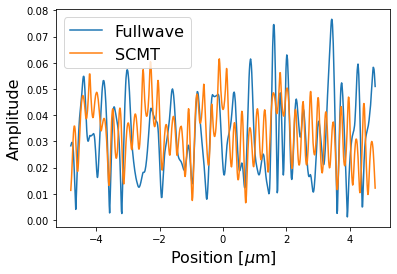

In [173]:
plt.figure()
plt.plot(x, amp_fullwave_norm, label = 'Fullwave')
#plt.plot(x, phase_pba, label = 'LPA')
plt.plot(x, amp_no_coupling_norm, label = 'SCMT')
plt.xlabel(r'Position [$\mu$m]',fontsize = 16)
plt.ylabel('Amplitude',fontsize = 16)
plt.legend(fontsize = 16)
print("relative error%: ", cal_relative_err(amp_no_coupling_norm, amp_fullwave_norm) * 100)
plt.savefig('near_field_no_coupling_amp_comparison.eps')